In [123]:
import dynesty
from dynesty import plotting as dyplot

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import os

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

import random

%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.5f' % x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
nwalk = 64
nsteps = 1000
ndiscard = 500
arrlen = (nsteps-ndiscard)*nwalk

In [126]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## The Sample

In [127]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_incmissing.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = pd.read_csv('spectplanets.csv')

# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = muirhead_gaia.rename(columns={"source_id": "m_source_id"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.read_csv('muirhead_comb.csv')

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = pd.read_csv('muirhead_comb_lums.csv')

/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


# Defining a "test planet"

In [128]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

In [129]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

In [130]:
mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [131]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

# Creating a fake light curve based on a real planet

In [132]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, inc, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', inc)

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98


# --------------------------------------------------------------------------------------

# $e = 0.0$, $\omega = 90.0$

# --------------------------------------------------------------------------------------

In [133]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(-25, 25, cadence)

In [134]:
# Calculate flux from transit model
e = 0.0
w = 90.0
flux = ph.integratedlc(time, period, rprs, a_rs, e, i, w)

# Adding some gaussian noise
noise = np.random.normal(0,0.00006,len(time))
nflux = flux+noise

flux_err = np.array([0.00006]*len(nflux))

# Fitting the transit

In [135]:
periodPDF = ph.get_period_dist(time, nflux, 4, 6, arrlen)

In [136]:
print('Period fit: ', ph.mode(periodPDF))
pdist = periodPDF
per_guess = ph.mode(pdist)

Period fit:  4.849699398797595


In [137]:
ttimes = np.concatenate((-np.arange(0, time[-1], period)[1:], np.arange(0, time[-1], period)))
ttimes = np.sort(ttimes)

time, flux, flux_err = ph.get_transit_cutout_full(ttimes, 4, time, nflux, flux_err)

t0 = 0.0

# Dynesty Transit Fit Likelihood Functions

In [138]:
ndim = 5

def tfit_loglike(theta):
    """
    Transit fit dynesty function

    model = ph.integratedlc_fitter()
    gerr = sigma of g distribution

    """

    per, rprs, a_rs, inc, t0 = theta

    model = ph.integratedlc_fitter(time, per, rprs, a_rs, inc, t0)
    sigma2 = flux_err ** 2

    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))


def tfit_prior_transform(utheta):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    uper, urp, ua, uinc, ut0 = utheta

    per = 3.*uper+3.
    rprs = urp
    a_rs = ua*15.+20.
    inc = uinc*3.+87.
    t0 = 2.*ut0-1.

    return per, rprs, a_rs, inc, t0

## Run dynesty transit fit

In [141]:
dsampler = dynesty.DynamicNestedSampler(tfit_loglike, tfit_prior_transform, ndim=ndim, nlive=1500,
                                        bound='balls', sample='rwalk')

In [142]:
dsampler.run_nested()

5197it [07:29,  7.19it/s, batch: 0 | bound: 62 | nc: 162 | ncall: 143876 | eff(%):  3.600 | loglstar:   -inf < -3616.777 <    inf | logz: -3632.662 +/-  0.246 | dlogz: 3901.591 >  0.010]/Users/ssagear/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
7788it [10:52, 13.63it/s, batch: 0 | bound: 98 | nc: 25 | ncall: 210923 | eff(%):  3.684 | loglstar:   -inf < -231.780 <    inf | logz: -252.928 +/-  0.286 | dlogz: 1005.770 >  0.010]   /Users/ssagear/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
29373it [42:07, 11.62it/s, batch: 8 | bound: 337 | nc: 25 | ncall: 742874 | eff(%):  3.954 | loglstar: 806.329 < 812.871 < 811.463 | l

In [143]:
dres = dsampler.results

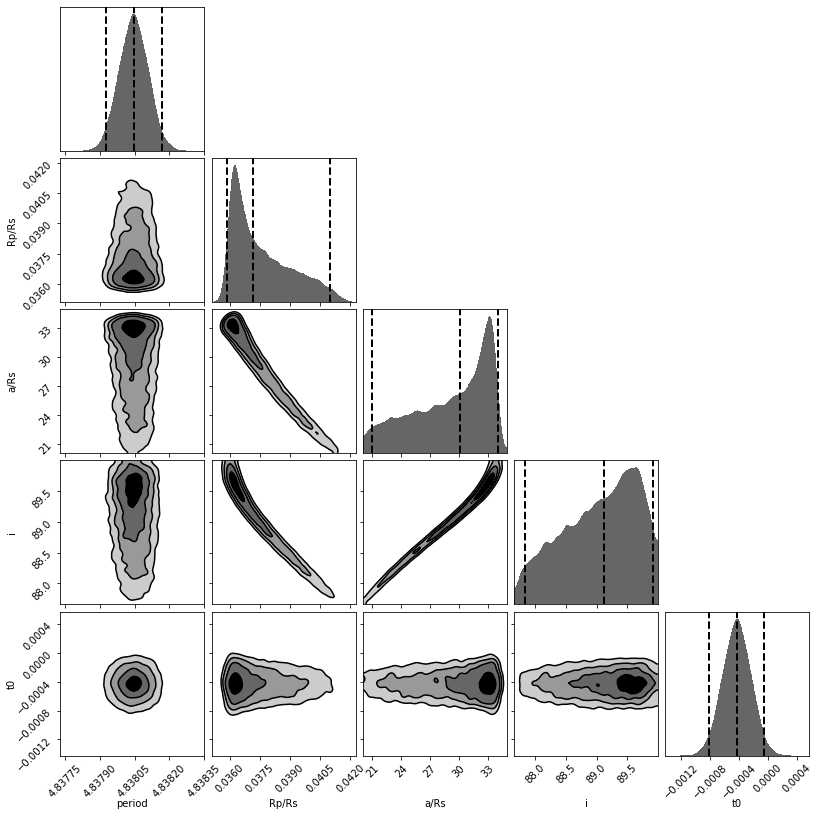

In [144]:
# Corner Plot of Transit Fit
fig, axes = dyplot.cornerplot(dres, labels=["period", "Rp/Rs", "a/Rs", "i", "t0"])

In [145]:
# Thinning distributions to size arrlen

pdist = random.choices(dres.samples[:,0], k=arrlen)
rdist = random.choices(dres.samples[:,1], k=arrlen)
adist = random.choices(dres.samples[:,2], k=arrlen)
idist = random.choices(dres.samples[:,3], k=arrlen)
t0dist = random.choices(dres.samples[:,4], k=arrlen)

per_f = ph.mode(pdist)
rprs_f = ph.mode(rdist)
a_f = ph.mode(adist)
i_f = ph.mode(idist)
t0_f = ph.mode(t0dist)

In [146]:
# Create a light curve with the fit parameters
fit1 = ph.integratedlc_fitter(time1, per_f, rprs_f, a_f, i_f, t0_f)

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314


Input params:
Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98


Fit params:
Rp/Rs:  0.03611389217940642
a/Rs:  32.943125204754864
i (deg):  89.50078494390452


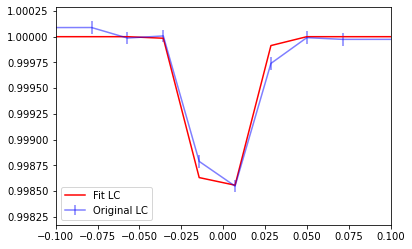

In [147]:
plt.errorbar(time1, nflux1, yerr=fluxerr1, c='blue', alpha=0.5, label='Original LC')
plt.plot(time1, fit1, c='red', alpha=1.0, label='Fit LC')
plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)

print('\n')

print('Input params:')
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

print('\n')

print('Fit params:')
print('Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)

### Determining T14 and T23

In [148]:
T14dist = ph.get_T14(pdist, rdist, adist, idist)
T14errs = ph.get_sigmas(T14dist)

T23dist = ph.get_T23(pdist, rdist, adist, idist)
T23errs = ph.get_sigmas(T23dist)

/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:61: RuntimeWarning: invalid value encountered in sqrt
  T14[j] = (p[j]/np.pi)*np.arcsin(rs_a[j]*(np.sqrt(((1+rprs[j])**2)-b[j]**2))/np.sin(i[j]*(np.pi/180.0))) #Equation 14 in exoplanet textbook
/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:113: RuntimeWarning: invalid value encountered in sqrt
  T23[j] = (p[j]/np.pi)*np.arcsin(rs_a[j]*(np.sqrt(((1-rprs[j])**2)-b[j]**2))/np.sin(i[j]*(np.pi/180.0))) #Equation 14 in exoplanet textbook


# Get $g$

In [149]:
gs, rho_c = ph.get_g_distribution(rho_star, pdist, rdist, T14dist, T23dist)

g_mean = ph.mode(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

In [150]:
g_mean

0.8323833968761061

In [151]:
g_sigma

0.1669271464088602

In [152]:
g = g_mean
gerr = g_sigma

# Dynesty (e,w) Fitting LIkelihood Functions

In [153]:
ndim = 2

def loglike(theta):
    """The log-likelihood function."""

    w, e = theta
    
    model = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2 = gerr ** 2
    
    return -0.5 * np.sum((g - model) ** 2 / sigma2 + np.log(sigma2))

def unife_prior_transform(utheta):
    """Uniform eccentricity prior"""
    
    uw, ue = utheta
    w = 360.*uw-90.
    e = 1. * ue
    
    return w, e


def betae_prior_transform(utheta):
    """Uniform eccentricity prior"""
    
    uw, ue = utheta
    w = 360.*uw-90.
    
    a, b = 0.867, 3.03
    e = scipy.stats.beta.ppf(ue, a, b)
    
    return w, e

## Uniform Prior

In [154]:
dsampler = dynesty.DynamicNestedSampler(loglike, unife_prior_transform, ndim=2, bound='multi', sample='rstagger')

In [ ]:
dsampler.run_nested()

16045it [01:20, 129.23it/s, batch: 13 | bound: 0 | nc: 7 | ncall: 85243 | eff(%): 18.654 | loglstar: -3.485 <  1.528 <  1.639 | logz:  0.643 +/-  0.049 | stop:  1.058]          

In [ ]:
dres = dsampler.results

In [ ]:
truths = [w, e]

fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, title_kwargs={'y': 1.04}, labels=["w", "e"],
                              fig=plt.subplots(2, 2, figsize=(8, 8)))

## Beta-distribution Prior

In [ ]:
dsampler = dynesty.DynamicNestedSampler(loglike, betae_prior_transform, ndim=2, bound='multi', sample='rstagger')

In [ ]:
dsampler.run_nested()

In [ ]:
dres = dsampler.results

In [ ]:
truths = [w, e]

In [ ]:
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, title_kwargs={'y': 1.04}, labels=["w", "e"],
                              fig=plt.subplots(2, 2, figsize=(8, 8)))

# --------------------------------------------------------------------------------------

# $e = 0.9$, $\omega = -85.0$

# --------------------------------------------------------------------------------------

In [ ]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(-25, 25, cadence)

In [ ]:
# Calculate flux from transit model
e = 0.9
w = -85.0
flux = ph.integratedlc(time, period, rprs, a_rs, e, i, w)

# Adding some gaussian noise
noise = np.random.normal(0,0.00006,len(time))
nflux = flux+noise

flux_err = np.array([0.00006]*len(nflux))

# Fitting the transit

In [ ]:
periodPDF = ph.get_period_dist(time, nflux, 4, 6, arrlen)

In [ ]:
print('Period fit: ', ph.mode(periodPDF))
pdist = periodPDF
per_guess = ph.mode(pdist)

In [ ]:
ttimes = np.concatenate((-np.arange(0, time[-1], period)[1:], np.arange(0, time[-1], period)))
ttimes = np.sort(ttimes)

time, flux, flux_err = ph.get_transit_cutout_full(ttimes, 4, time, nflux, flux_err)

t0 = 0.0

# Dynesty Transit Fit Likelihood Functions

In [ ]:
ndim = 5

def tfit_loglike(theta):
    """
    Transit fit dynesty function

    model = ph.integratedlc_fitter()
    gerr = sigma of g distribution

    """

    per, rprs, a_rs, inc, t0 = theta

    model = ph.integratedlc_fitter(time, per, rprs, a_rs, inc, t0)
    sigma2 = flux_err ** 2

    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))


def tfit_prior_transform(utheta):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    uper, urp, ua, uinc, ut0 = utheta

    per = 3.*uper+3.
    rprs = urp
    a_rs = ua*15.+5.
    inc = uinc*3.+87.
    t0 = 2.*ut0-1.

    return per, rprs, a_rs, inc, t0

## Run dynesty transit fit

In [ ]:
dsampler = dynesty.DynamicNestedSampler(tfit_loglike, tfit_prior_transform, ndim=ndim, nlive=1500,
                                        bound='multi', sample='rwalk')

In [ ]:
# Capped at 10,000 iterations
dsampler.run_nested(maxiter=10000)

In [ ]:
dres = dsampler.results

In [ ]:
# Corner Plot of Transit Fit
fig, axes = dyplot.cornerplot(dres, labels=["period", "Rp/Rs", "a/Rs", "i", "t0"])

In [ ]:
# Thinning distributions to size arrlen

pdist = random.choices(dres.samples[:,0], k=arrlen)
rdist = random.choices(dres.samples[:,1], k=arrlen)
adist = random.choices(dres.samples[:,2], k=arrlen)
idist = random.choices(dres.samples[:,3], k=arrlen)
t0dist = random.choices(dres.samples[:,4], k=arrlen)

per_f = ph.mode(pdist)
rprs_f = ph.mode(rdist)
a_f = ph.mode(adist)
i_f = ph.mode(idist)
t0_f = ph.mode(t0dist)

In [ ]:
# Create a light curve with the fit parameters
fit1 = ph.integratedlc_fitter(time1, per_f, rprs_f, a_f, i_f, t0_f)

In [ ]:
plt.errorbar(time1, nflux1, yerr=fluxerr1, c='blue', alpha=0.5, label='Original LC')
plt.plot(time1, fit1, c='red', alpha=1.0, label='Fit LC')
plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)

print('\n')

print('Input params:')
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

print('\n')

print('Fit params:')
print('Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)

### Determining T14 and T23

In [ ]:
T14dist = ph.get_T14(pdist, rdist, adist, idist)
T14errs = ph.get_sigmas(T14dist)

T23dist = ph.get_T23(pdist, rdist, adist, idist)
T23errs = ph.get_sigmas(T23dist)

# Get $g$

In [ ]:
gs, rho_c = ph.get_g_distribution(rho_star, pdist, rdist, T14dist, T23dist)

g_mean = ph.mode(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

In [ ]:
g_mean

In [ ]:
g_sigma

In [ ]:
g = g_mean
gerr = g_sigma

# Dynesty (e,w) Fitting LIkelihood Functions

In [ ]:
ndim = 2

def loglike(theta):
    """The log-likelihood function."""

    w, e = theta
    
    model = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2 = gerr ** 2
    
    return -0.5 * np.sum((g - model) ** 2 / sigma2 + np.log(sigma2))

def unife_prior_transform(utheta):
    """Uniform eccentricity prior"""
    
    uw, ue = utheta
    w = 360.*uw-90.
    e = 1. * ue
    
    return w, e


def betae_prior_transform(utheta):
    """Uniform eccentricity prior"""
    
    uw, ue = utheta
    w = 360.*uw-90.
    
    a, b = 0.867, 3.03
    e = scipy.stats.beta.ppf(ue, a, b)
    
    return w, e

## Uniform Prior

In [ ]:
dsampler = dynesty.DynamicNestedSampler(loglike, unife_prior_transform, ndim=2, bound='multi', sample='rstagger')

In [ ]:
dsampler.run_nested()

In [ ]:
dres = dsampler.results

In [ ]:
truths = [w, e]

fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, title_kwargs={'y': 1.04}, labels=["w", "e"],
                              fig=plt.subplots(2, 2, figsize=(8, 8)))

## Beta-distribution Prior

In [ ]:
dsampler = dynesty.DynamicNestedSampler(loglike, betae_prior_transform, ndim=2, bound='multi', sample='rstagger')

In [ ]:
dsampler.run_nested()

In [ ]:
dres = dsampler.results

In [ ]:
truths = [w, e]

In [ ]:
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, title_kwargs={'y': 1.04}, labels=["w", "e"],
                              fig=plt.subplots(2, 2, figsize=(8, 8)))